### Projection Rectification
#### Theory
Projection rectification is the process of undoing distortions to shapes, caused by projecting a 3D object down to a 2D image.
Projection rectification can be achieved in several way, the simplest way is:

- Marking 4 points in the original image, preferrably of a recognizable shape, like a square
- Specifying the new coordinate of the 4 points that we want
- Solving for the projective transformation.

Suppose points are $x_1, x_2, x_3, x_4$ and $x_1', x_2', x_3', x_4'$, then: 
$$
Hx_i = x_i' \to H\cdot [x_1 \ x_2 \ x_3 \ x_4] = [x_1' \ x_2' \ x_3' \ x_4']
$$

Problem: $H$ is 3x3, but $[x_1 \ x_2 \ x_3 \ x_4]$ and $[x_1' \ x_2' \ x_3' \ x_4']$ are 3x4. This is because $x_i$ are given in projective coordinates that is defined only up to scale.



Approach 1: Dirty fix. Take advantage of $x_i' \times Hx_i = 0$ (Ref: p89)
Flatten H as
$$
H = 
\begin{bmatrix}
        h_1  & h_2 & h_3\\
        h_4  & h_5 & h_6\\
        h_7  & h_8 & h_9\\
\end{bmatrix}
\to
\mathbf{h}
    = \begin{bmatrix}
        \vec h_1  \\
        \vec h_2 \\
        \vec h_3 
    \end{bmatrix}_{9 \times 1} = \begin{bmatrix}
        \vec h_1 \\
        \vec h_2 \\
        \vec h_3 \\
        \vec h_4 \\
        \vec h_5 \\
        \vec h_6 \\
        \vec h_7 \\
        \vec h_8 \\
        \vec h_9 \\
    \end{bmatrix}_{9 \times 1}
$$
Where $h_i$ is the $i$-th row of $H$ transposed, of dimension $3 \times 1$, and 
$\mathbf{x_i}^T = (x_i, y_i, w_i)$
Then the equation becomes
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
        -y_i'\mathbf{x_i^T} & x_i'\mathbf{x_i^T} & 0^T
\end{bmatrix}_{3 \times 9} h = \mathbf{0}
$$
Since H is defined up to scale, the last row is ommitted: 
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
\end{bmatrix}_{2 \times 9} h = \mathbf{0} \to A_ih = 0
$$
Each $i$ gives two equations for a total of 8 equations. This can be solved by locking $h_9$ = 1 because of projective coordinates, but this is a dirty solution (we'll see why)

#### Step 1. Determining 4 corresponding points

In [9]:
%matplotlib widget
# Load image, put on plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image = plt.imread('../images/floor.jpg')
# Display the image

# selecting 4 points, put them on the image
x = np.array([[132,379], [198, 435], [276,370], [210, 327]])
x_coords, y_coords = zip(*x)


# And the corresponding points where we want them to be after the distortion undo
x_prime = np.array([[200, 300], [300, 300], [300, 200], [200,200]])


xp_coords, yp_coords = zip(*x_prime)


(480, 480, 3)


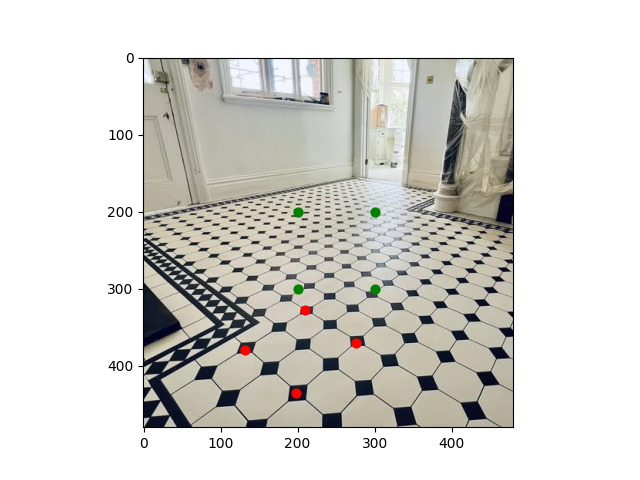

In [10]:

fig, ax = plt.subplots()
ax.imshow(image)
print(image.shape)
ax.scatter(x_coords, y_coords, color="red", s=40)
ax.scatter(xp_coords, yp_coords, color="green", s=40)

#### Step 2: Solve H

In [11]:
# form the matrix 
def get_Ai(x, xp):
    # convert x_i, xp_i to homogeneous coords
    x_i = np.concatenate((x, [1]))
    xp_i = np.concatenate((xp, [1]))
    row1 = np.concatenate((
        np.zeros(3),
        -xp_i[-1]*x_i,
        xp_i[1]*x_i
    )
    )
    row2 = np.concatenate((
         xp_i[-1]*x_i,
         np.zeros(3),
         -xp_i[0]*x_i
    ))
    return np.array([row1, row2])

def get_A(x, x_prime):
    A = np.zeros((0,9))
    for i in range(x.shape[0]):
        Ai = get_Ai(x[i], x_prime[i])
        A = np.concatenate((A,Ai))
    return A


In [14]:

A = get_A(x, x_prime)
b = np.zeros(9)
# Enforce h_9 = 1 
A = np.concatenate((A, [[0,0,0,0,0,0,0,0,1]]))
b[-1] = 1

# solve for H
h = np.linalg.solve(A, b)
print(h)
# reshape h into H
H = h.reshape((3,3))
print(H)

[ 5.18381985e+00  1.08834498e+01 -3.42926401e+03 -4.36883333e+00
  9.82204387e+00 -1.07612710e+03  1.42883678e-05  1.55600326e-02
  1.00000000e+00]
[[ 5.18381985e+00  1.08834498e+01 -3.42926401e+03]
 [-4.36883333e+00  9.82204387e+00 -1.07612710e+03]
 [ 1.42883678e-05  1.55600326e-02  1.00000000e+00]]


Confirm that x had been transformed to x_prime

In [29]:
x_p = H @ (np.hstack((x, np.ones((4,1))))).T
# convert back to (x, y, 1) form
x_p = x_p * 1/x_p[-1]
x_p = x_p[:-1, :].reshape((-1, 2))

In [30]:
print(x)
print(x_p)

[[132 379]
 [198 435]
 [276 370]
 [210 327]]
[[200. 300.]
 [300. 200.]
 [300. 300.]
 [200. 200.]]


#### Step 3. Apply H on the image

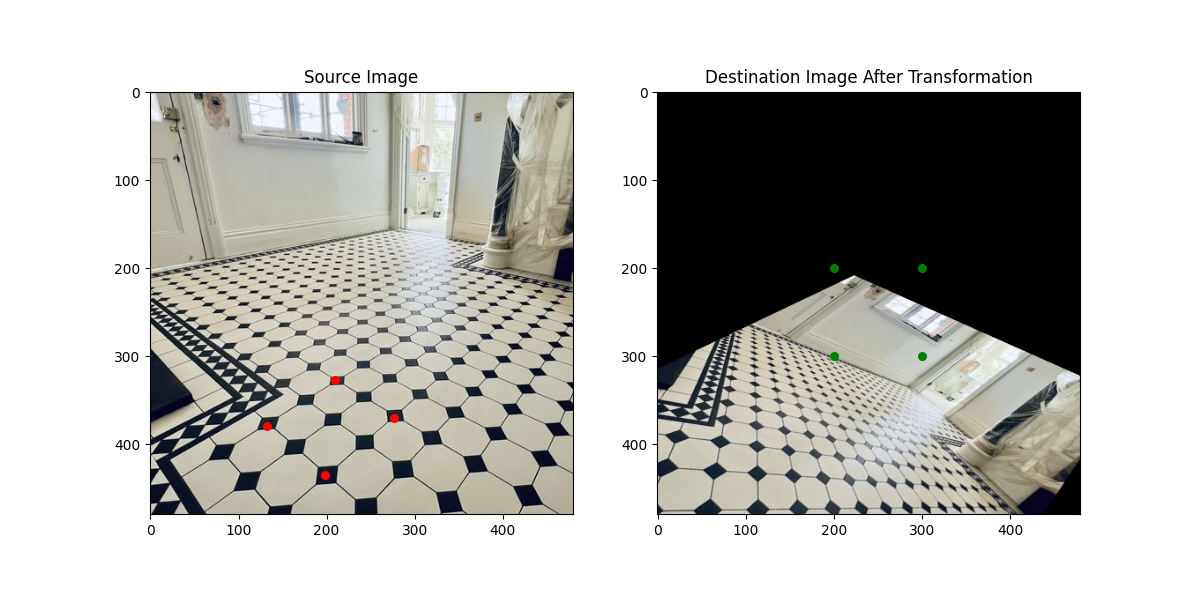

In [31]:
%matplotlib widget
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, warp
import numpy as np

im_src = imread('../images/floor.jpg')
height, width, dim = im_src.shape
im_dst = np.zeros((height, width, dim))


im_dst = warp(im_src, H, output_shape=(height, width))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)
x_coords, y_coords = zip(*x)
plt.scatter(x_coords, y_coords, s=30, color="red")
plt.title('Source Image')
plt.subplot(122)
plt.imshow(im_dst)
x_coords, y_coords = zip(*x_p)
plt.scatter(x_coords, y_coords, s=30, color="green")
plt.title('Destination Image After Transformation')
plt.show()

#### Commercial solution

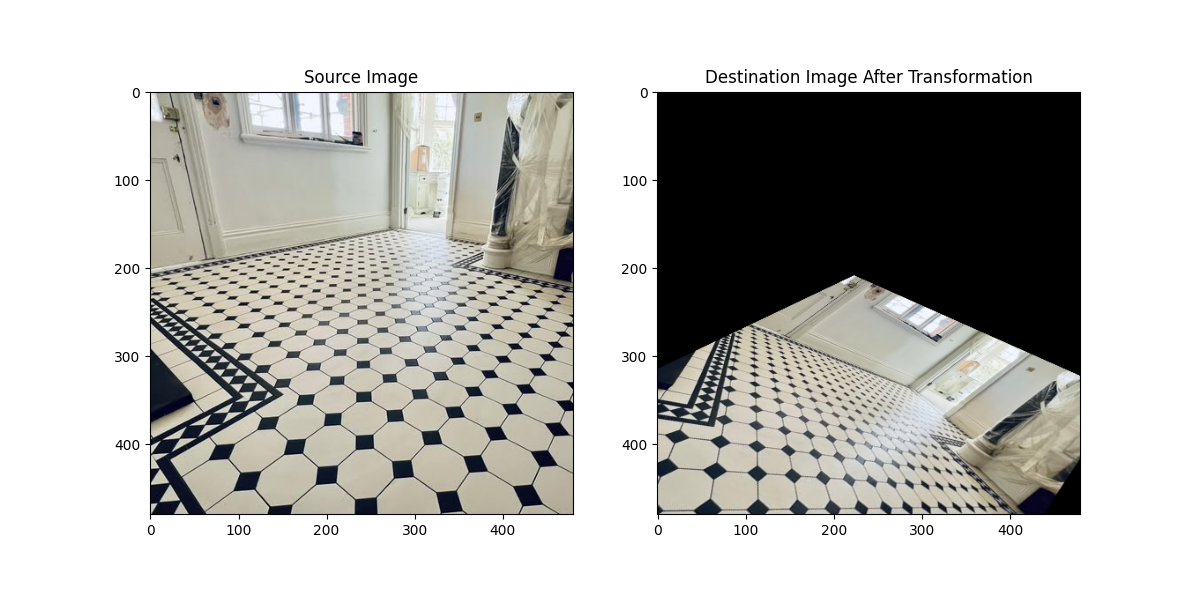

In [33]:
%matplotlib widget
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, warp
import numpy as np

im_src = imread('../images/floor.jpg')
height, width, dim = im_src.shape
im_dst = np.zeros((height, width, dim))

pt = ProjectiveTransform()

pt.estimate(x, x_prime)

im_dst = warp(im_src, pt, output_shape=(height, width))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)
ax.scatter(x_coords, y_coords, color="red", s=40)
ax.scatter(xp_coords, yp_coords, color="green", s=40)
plt.title('Source Image')
plt.subplot(122)
plt.imshow(im_dst)
plt.title('Destination Image After Transformation')
plt.show()

#### Interpretation
The commercial solution and our solution is identical. Great!
But... we did not achieve the rectification effect. The red and green points on the scene don't even seem to be from the same point in the scene. Yet 
the transformation is doing what it should: 